In [156]:
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
import matplotlib.pyplot as plt


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import and Preporcess the Data

In [64]:
res_df = pd.read_csv('Resume/Resume.csv')
job_df = pd.read_csv('JobDescription/training_data.csv')

In [93]:
possible_categories = []
for str_resume in res_df['Resume_str']:
    temp = str_resume.split("     ")
    temp = [x for x in temp if len(x.split(" ")) == 1 and x != '']
    possible_categories += temp
    possible_categories = list(set(possible_categories))

In [179]:
# after analysing possible categories, we can see that the following are the possible categories
cv_categories = ['Summary', 'Experience', 'Education', 'Skills', 'Portfolio', 'Publications', 'Accomplishments', 'Certifications', 'Interests', 'Credentials', 'Projects']

stop_words = set(stopwords.words('english')).union({'state', 'company', 'city', 'name'})
lemmatizer = WordNetLemmatizer()
cv_categories = [lemmatizer.lemmatize(cat) for cat in cv_categories]

def preprocess_text(text):
    text = text.lower()
    # remove stopwords and keep only words with alphanumerical characters (unless it is a date, e.g. '12/12/2012')
    text = ' '.join([word for word in text.split() if word not in stop_words and (word.isalnum() and not "/" in word)])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

def preprocess_cv(cv):
    cv = cv.replace("\n", " ")
    cv = cv.replace("\t", " ")

    # separate texts by category
    ind_cats = {cat: cv.find(cat) for cat in cv_categories}
    ind_cats = {k: v for k, v in sorted(ind_cats.items(), key=lambda item: item[1]) if v!=-1}
    ind_cats['end'] = -1
    keys = list(ind_cats.keys())
    # ind_cats contains categories and the first index they appear at and keys is an ordered list of the appearances of the categories
    cv_json = {cat: preprocess_text(cv[ind_cats[cat]+len(cat):ind_cats[keys[keys.index(cat)+1]]]) for cat in keys if ind_cats[cat] != -1}
    return cv_json


In [183]:
res_df['resume_json'] = res_df['Resume_str'].apply(preprocess_cv)
res_df['whole_resume'] = res_df['resume_json'].apply(lambda x: " ".join(list(x.values())))

final_df = res_df[['ID', 'resume_json', 'whole_resume', 'Category']]

# EDA categories

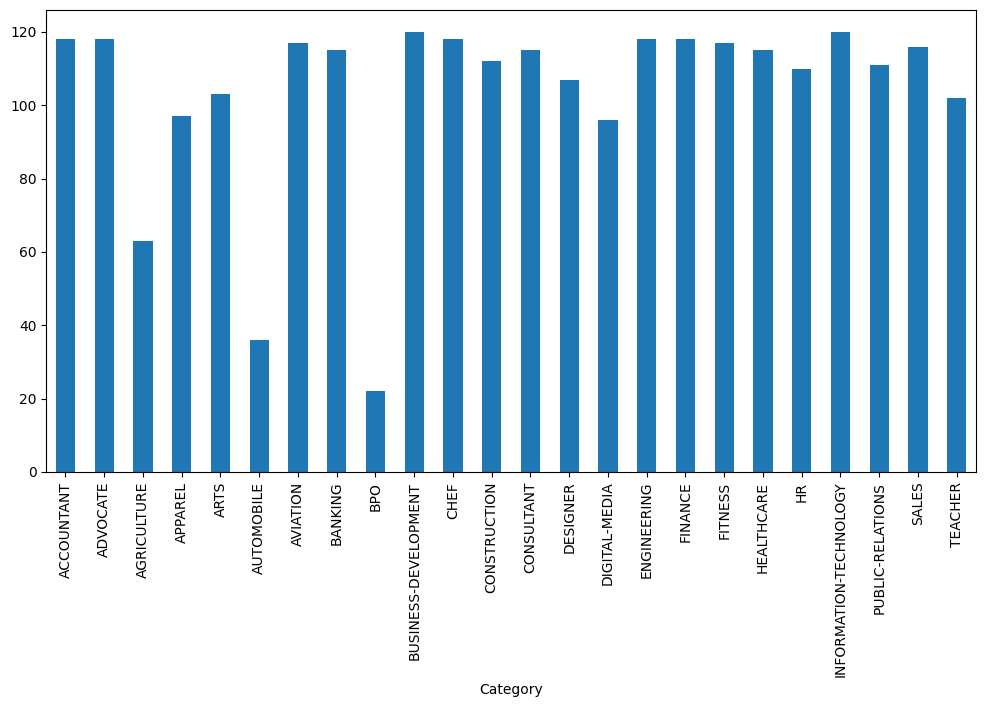

In [176]:
final_df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

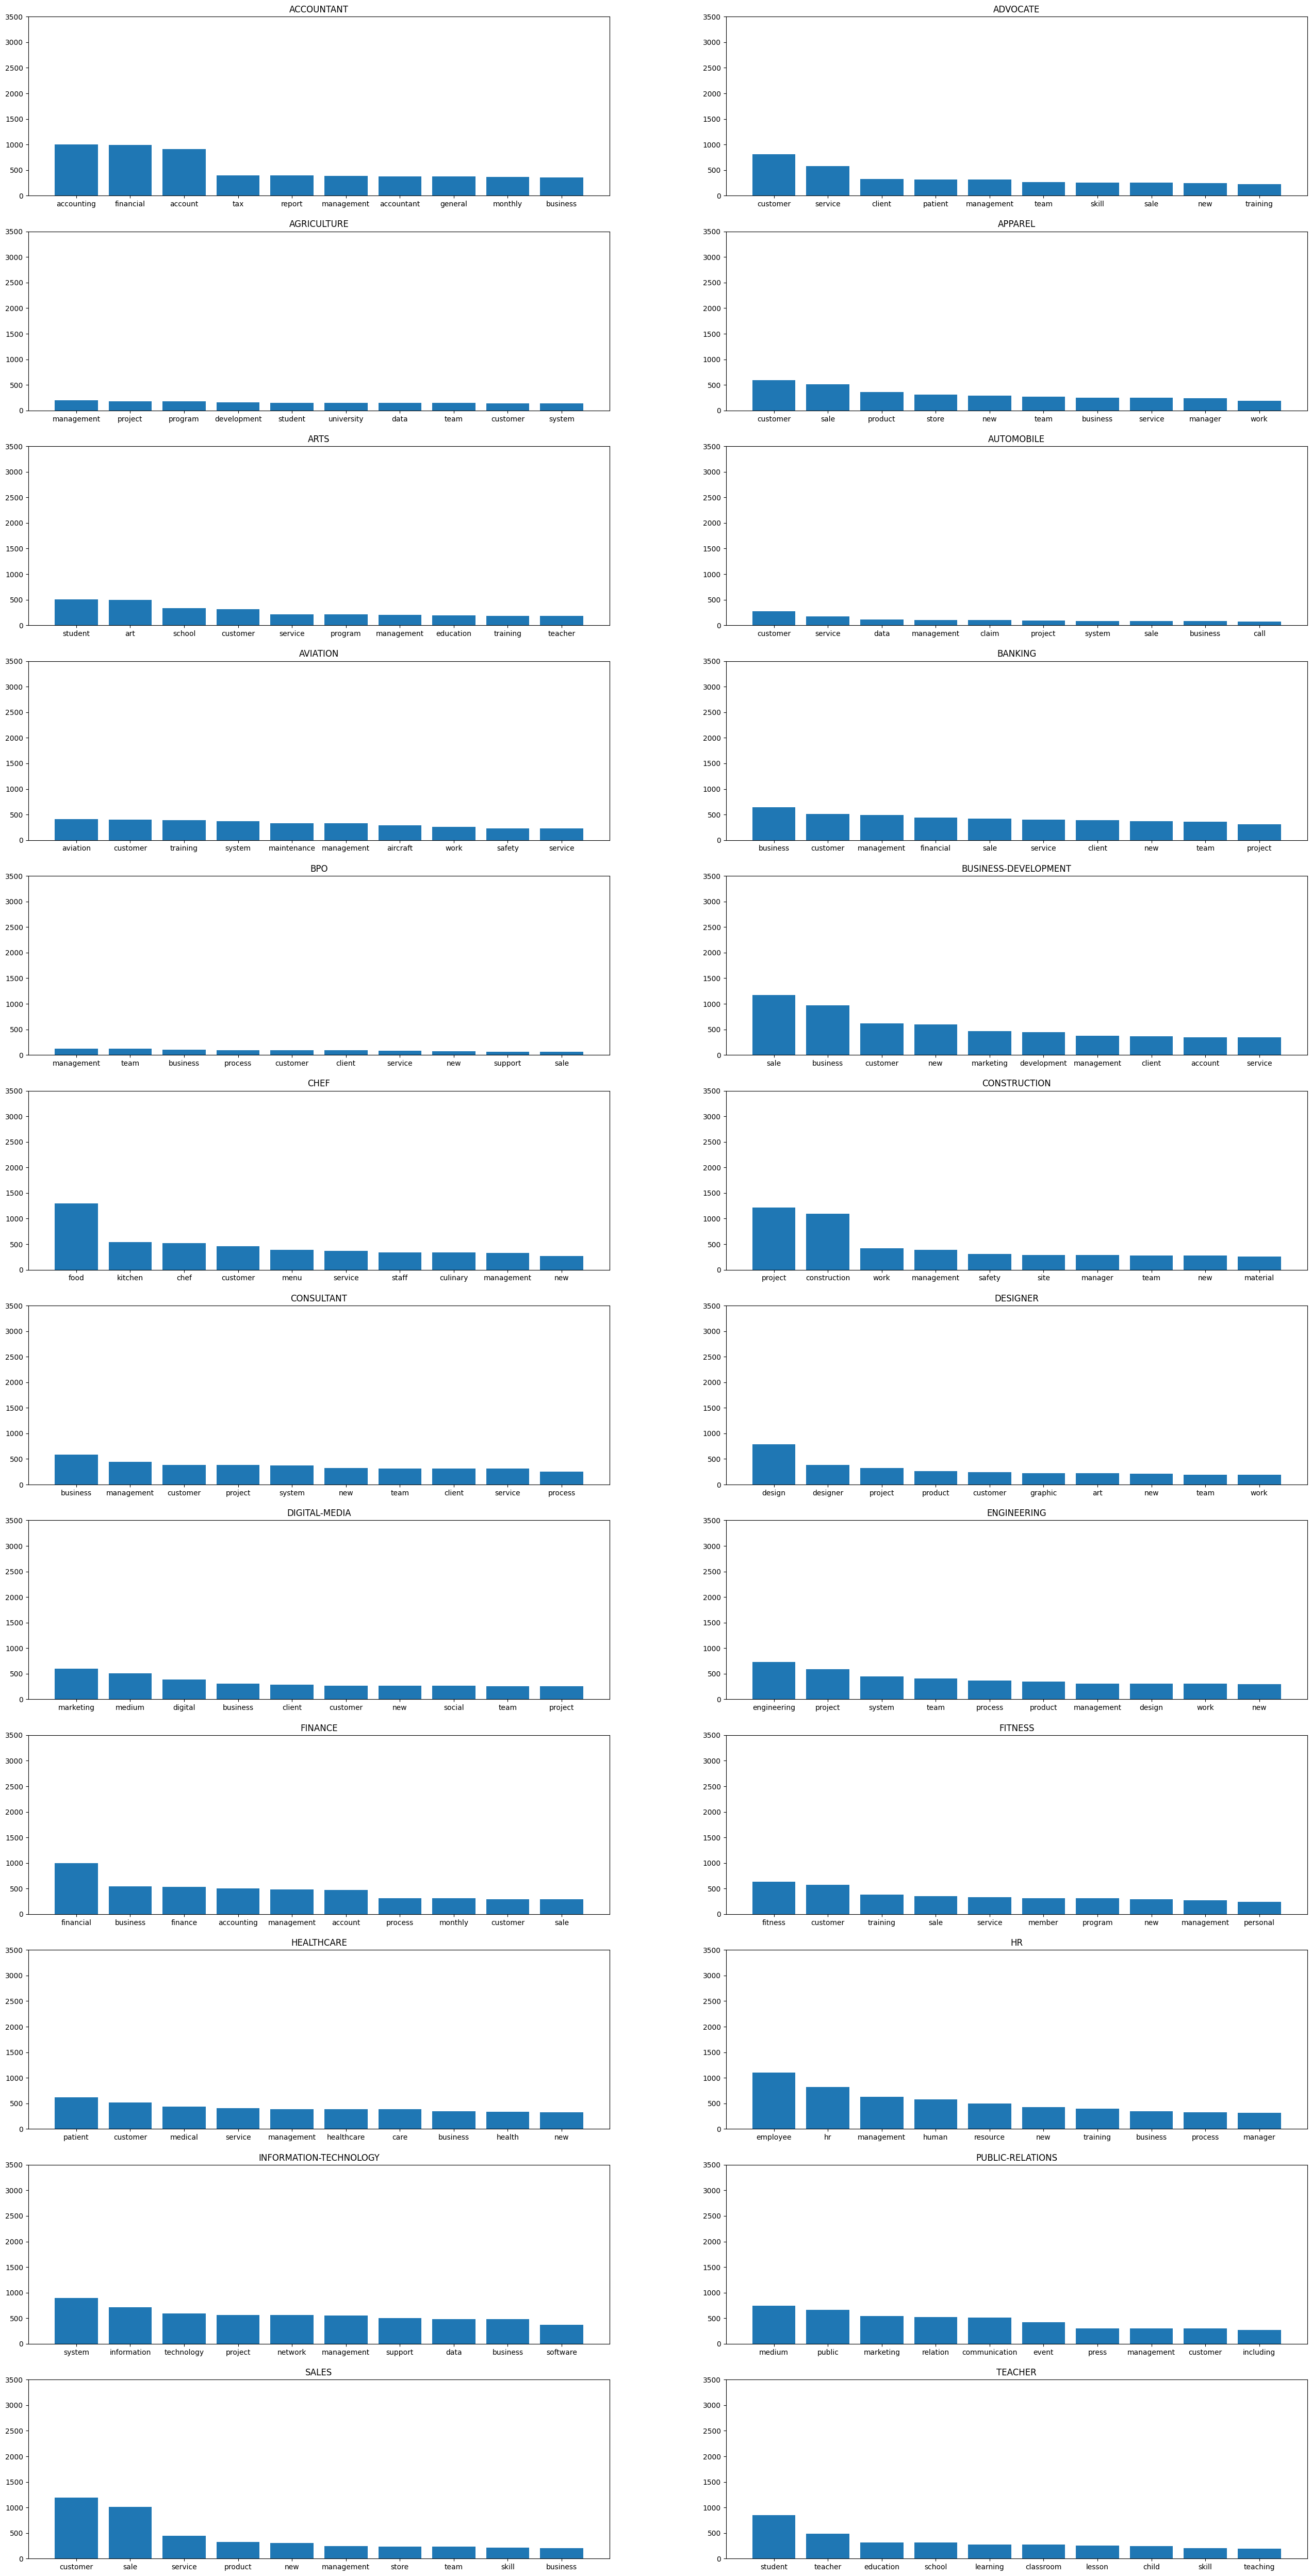

In [184]:
# word frequency for each category
def wordfreq(df):
    count = df['whole_resume'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

fig = plt.figure(figsize=(32, 64))

all_wf_words = []
for i, cat in enumerate(np.sort(final_df['Category'].unique())):
    wf = wordfreq(final_df[final_df['Category']==cat])
    all_wf_words += list(wf['Word']) 
    fig.add_subplot(12, 2, i + 1).set_title(cat)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()